## Environment setup

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import importlib
import uproot
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib import colors

## Data loading

### Load data from Tracks tree made with tpcReco

In [2]:
dataDirectory = "/scratch_hdd/akalinow/ELITPC/TPCReco/build/resources/"
dataFile = "TrackTree.root"

treeName = ":trackTree"
inputObj = dataDirectory+dataFile+treeName

with uproot.open(inputObj) as file:
    array = file["track"].array(library="pd")
    df = ak.to_dataframe(array)
    #columns = df.columns
    #columnsClean = [aCol[0] for aCol in columns]
    #df.columns = columnsClean
    
df_RECO = df.rename(columns={'xVtx':'RECO_StartPosX',
    'yVtx':'RECO_StartPosY',
    'zVtx':'RECO_StartPosZ',
    'xAlphaEnd':'RECO_StopPosX_Part1',
    'yAlphaEnd':'RECO_StopPosY_Part1',
    'zAlphaEnd':'RECO_StopPosZ_Part1',
    'xCarbonEnd':'RECO_StopPosX_Part2',
    'yCarbonEnd':'RECO_StopPosY_Part2',
    'zCarbonEnd':'RECO_StopPosZ_Part2'})

df_RECO.describe()

,eventId,frameId,eventType,length,horizontalLostLength,verticalLostLength,alphaEnergy,carbonEnergy,alphaRange,carbonRange,...,RECO_StopPosY_Part1,RECO_StopPosZ_Part1,RECO_StopPosX_Part2,RECO_StopPosY_Part2,RECO_StopPosZ_Part2,total_mom_x,total_mom_y,total_mom_z,lineFitChi2,dEdxFitChi2
count,10000.000000,10000.00000,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,9692.000000,10000.000000,10000.000000,9692.000000,10000.000000,10000.000000,1.000000e+04
mean,999.500000,4999.50000,6.150233e+07,47.081422,inf,inf,2.315263,0.828339,40.961539,7.420127,...,-1.468210,-50.611233,-0.858938,-1.222296,-49.373795,-2.889634,0.263169,4.051951,41.931352,8.397358e+06
std,577.379067,2886.89568,3.450202e+08,33.333784,NaN,NaN,1.506044,0.679085,30.515487,4.539466,...,31.535233,22.271717,57.791432,22.331075,25.268791,36.648280,32.267707,48.751188,22.818598,2.352607e+07
min,0.000000,0.00000,0.000000e+00,0.000000,7.507170e+01,6.000000e+00,0.000000,0.000000,0.000000,0.000000,...,-413.126923,-106.196236,-232.881287,-413.126923,-81.260956,-219.728180,-190.061081,-254.564331,0.000000,0.000000e+00
25%,499.750000,2499.75000,3.000000e+00,20.232110,1.206370e+02,7.198279e+00,1.097929,0.266214,17.397787,4.932248,...,-14.440137,-65.363438,-49.800436,-8.898387,-68.060110,-9.630302,-4.799782,-8.173581,36.536200,1.015223e+06
50%,999.500000,4999.50000,3.000000e+00,41.062809,1.957672e+02,9.112588e+00,2.217678,0.795471,34.709543,8.511467,...,-0.837107,-59.474838,0.000000,-0.123258,-59.778868,-2.750992,0.002990,1.327270,37.151464,1.686885e+06
75%,1499.250000,7499.25000,3.000000e+00,66.291721,4.335570e+02,1.197048e+01,3.367686,1.206827,58.175583,10.445347,...,13.022046,-42.621325,47.662728,8.346113,-37.783733,1.957836,5.320896,22.618330,40.343469,3.494694e+06
max,1999.000000,9999.00000,1.996829e+09,232.170380,inf,inf,8.358563,4.993041,222.409698,23.430000,...,349.795593,84.720078,288.008789,349.795593,67.938065,214.547348,184.822601,244.896103,312.302765,2.543102e+08


### Load a tree with generator level information. 

* select only interesting leafs
* rename the columns to match convention
* merge with reco tree

CPU times: user 200 ms, sys: 13.8 ms, total: 214 ms
Wall time: 725 ms


<Axes: >

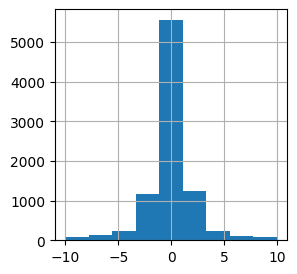

In [3]:
%%time 

fields = [
    #"SimEvent/reactionType",
    "SimEvent/tracks/tracks.startPos",
    "SimEvent/tracks/tracks.stopPos",
    #"SimEvent/tracks/tracks.prim.pID",
    #"SimEvent/tracks/tracks.prim.fourMomentum",
    #"Event/myChargeMap",
    #"Event/myChargeArray*",
    #"SimEvent/tracks/tracks.truncatedStartPosUVWT.*",
    #"SimEvent/tracks/tracks.truncatedStopPosUVWT.*",
]  

test_files = ['data/E_11_sigma_2/out_with_charge_map.root:TPCData']
batchSize = 10000
for array in uproot.iterate(test_files, step_size=batchSize, filter_name=fields, library="ak"):
    df = ak.to_dataframe(array)
    df_part1 = df.loc[(slice(None),0),:]
    df_part2 = df.loc[(slice(None),1),:]
    startXYZ = df_part1["tracks.startPos"]
    stopXYZ_part1 = df_part1["tracks.stopPos"]
    stopXYZ_part2 = df_part2["tracks.stopPos"]
    
    startXYZ = startXYZ.rename(columns={"fX":"GEN_StartPosX",
                                    "fY":"GEN_StartPosY",
                                    "fZ":"GEN_StartPosZ"}).reset_index(drop=True)
    
    stopXYZ_part1 = stopXYZ_part1.rename(columns={"fX":"GEN_StopPosX_Part1",
                                    "fY":"GEN_StopPosY_Part1",
                                    "fZ":"GEN_StopPosZ_Part1"}).reset_index(drop=True)
    
    stopXYZ_part2 = stopXYZ_part2.rename(columns={"fX":"GEN_StopPosX_Part2",
                                    "fY":"GEN_StopPosY_Part2",
                                    "fZ":"GEN_StopPosZ_Part2"}).reset_index(drop=True)
    
    df_GEN = pd.concat([startXYZ,stopXYZ_part1,stopXYZ_part2], axis=1)  

    break 
    
    
df = pd.concat([df_GEN, df_RECO], axis=1)

#Check datasets compatibility.
df[["GEN_StartPosX","GEN_StartPosY", "RECO_StartPosX", "RECO_StartPosY"]]
(df["GEN_StartPosX"] - df["RECO_StartPosX"]).hist(bins=np.linspace(-10,10,10), figsize=(3,3));

### Resolution plots

2023-05-30 18:13:36.567635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/scratch_hdd/akalinow/ELITPC/PythonAnalysis/utility_functions.py:69: RuntimeWarning: invalid value encountered in true_divide
  track1 /=norm
/scratch_hdd/akalinow/ELITPC/PythonAnalysis/utility_functions.py:73: RuntimeWarning: invalid value encountered in true_divide
  track2 /=norm


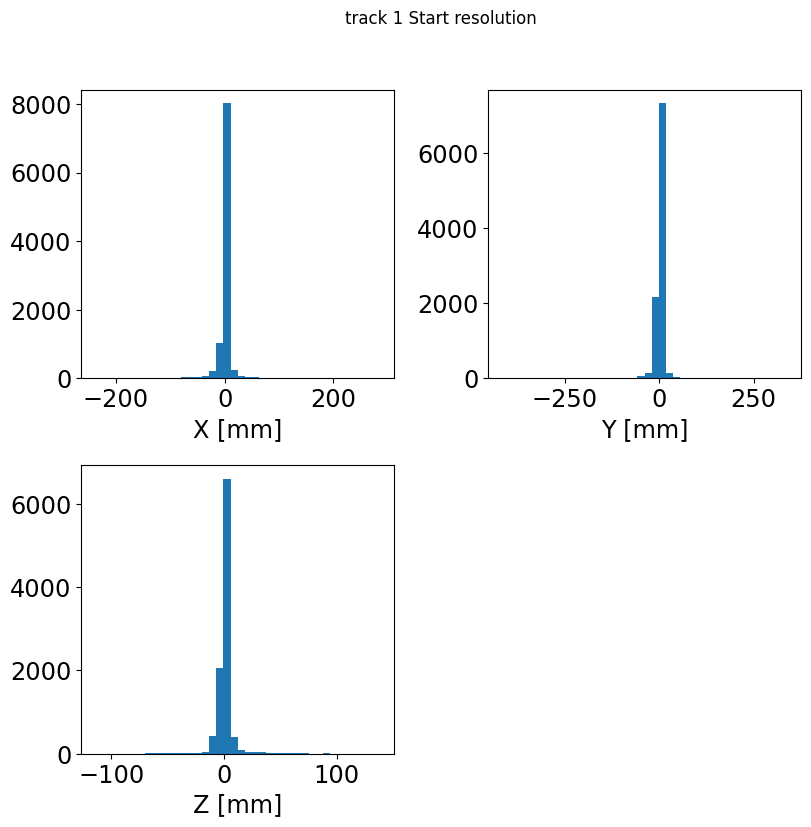

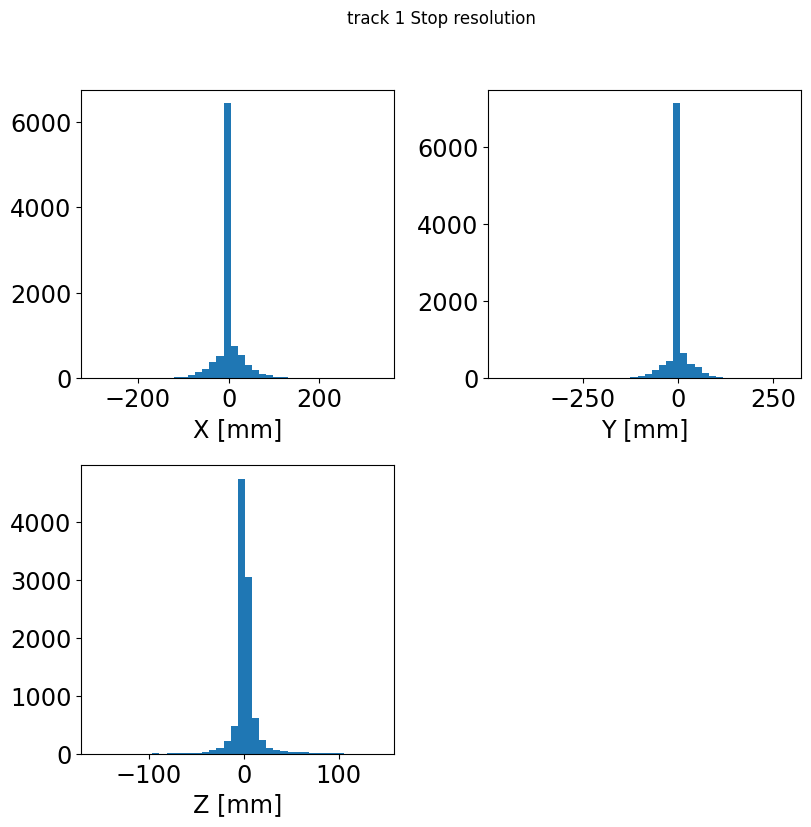

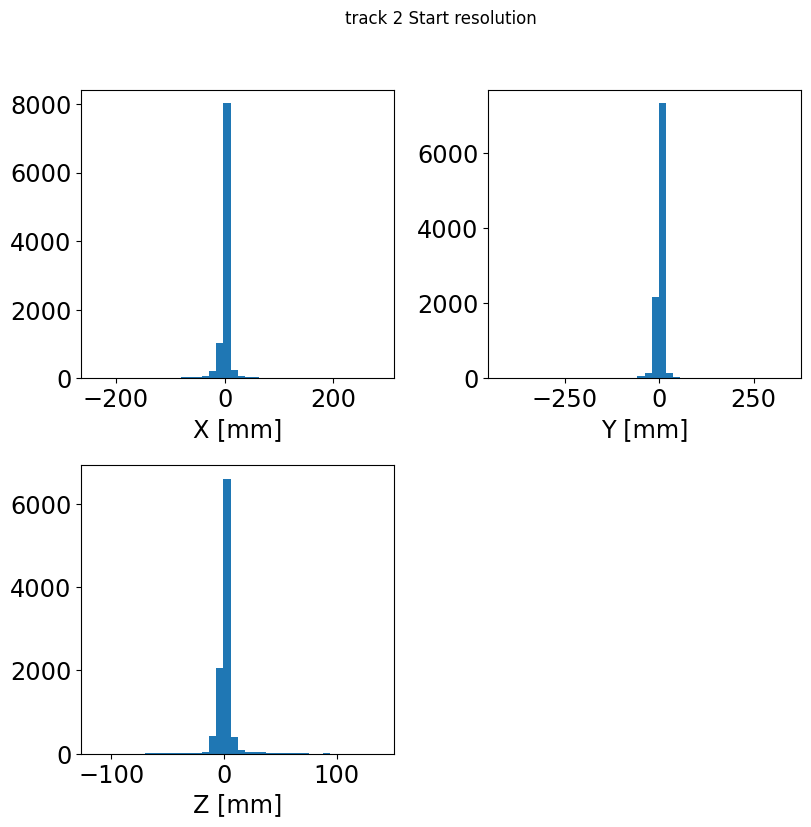

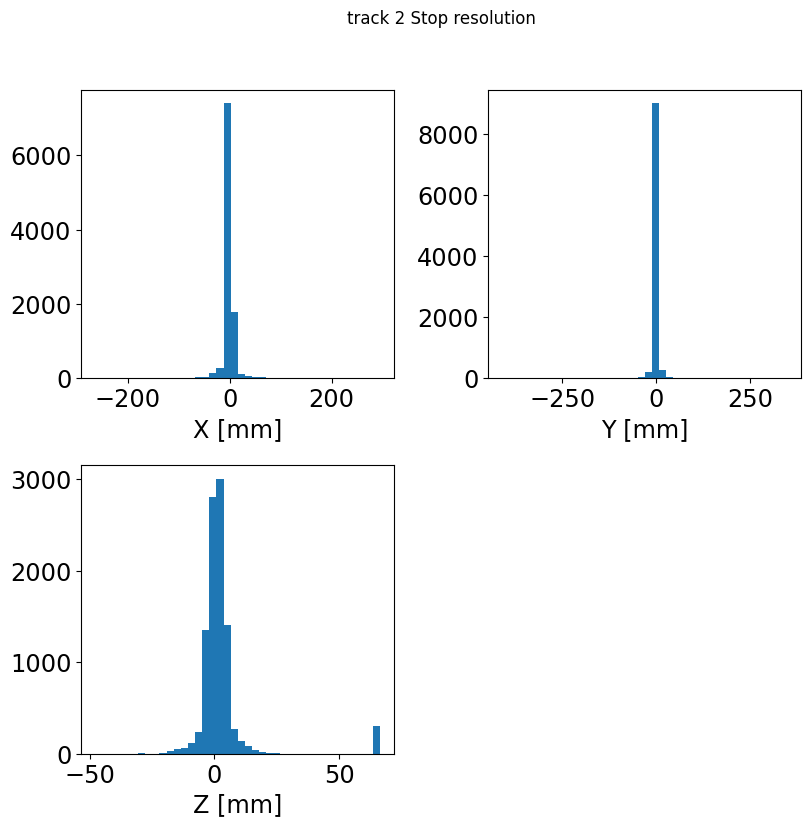

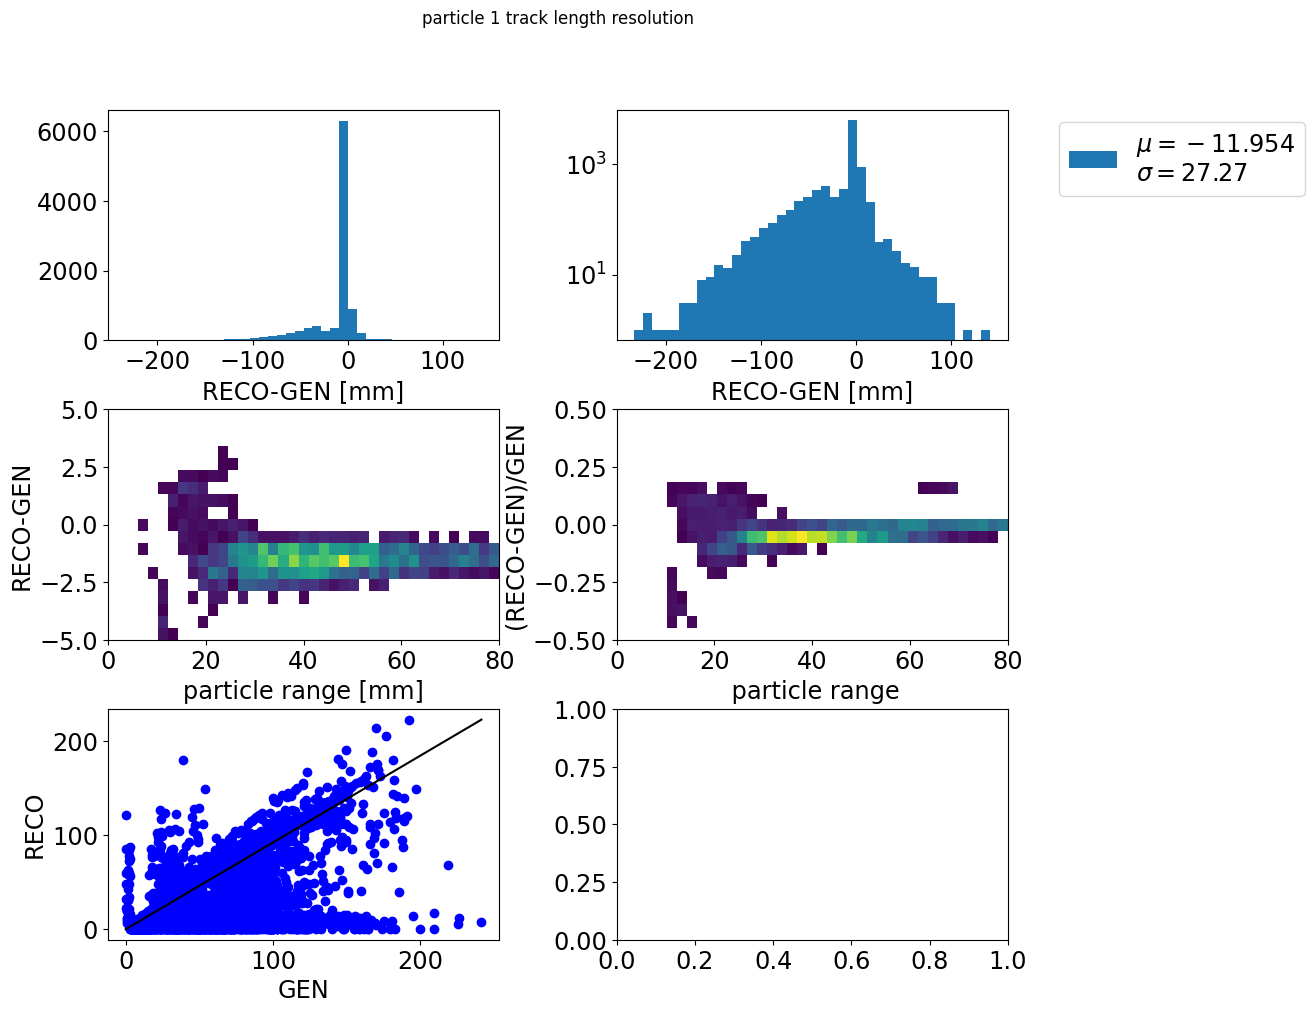

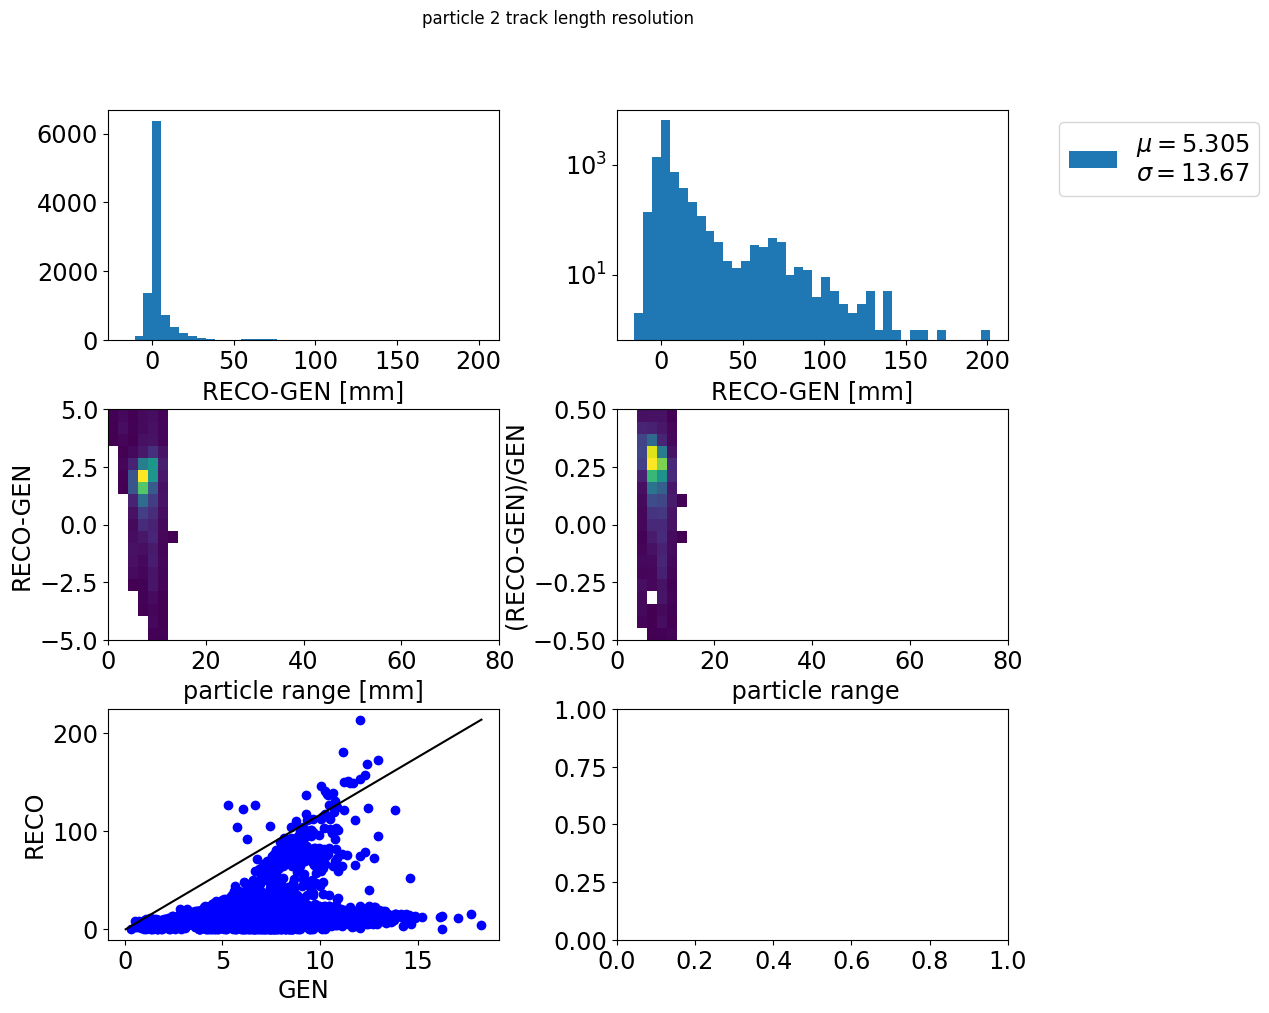

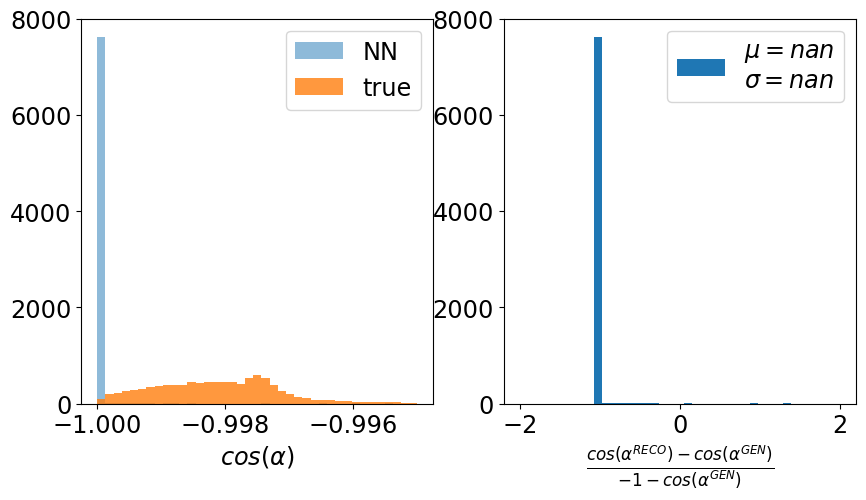

In [4]:
import plotting_functions as plf
importlib.reload(plf)

#plf.controlPlots(df)
plf.plotEndPointRes(df=df, edge="Start", partIdx=1)
plf.plotEndPointRes(df=df, edge="Stop", partIdx=1)

plf.plotEndPointRes(df=df, edge="Start", partIdx=2)
plf.plotEndPointRes(df=df, edge="Stop", partIdx=2)

plf.plotLengthPull(df, partIdx=1)
plf.plotLengthPull(df, partIdx=2)
plf.plotOpeningAngleCos(df)

### Resolution plots for filtered dataset

       GEN_StartPosX  GEN_StartPosY  GEN_StartPosZ  GEN_StopPosX_Part1  \
count    3973.000000    3973.000000    3973.000000         3973.000000   
mean       -0.729456       0.188882     -54.609349           -1.082256   
std        57.798958       9.893126      14.749582           65.269166   
min       -99.996529     -19.973033     -66.383551         -170.372055   
25%       -49.686856      -7.660975     -62.624263          -51.696549   
50%        -2.488831       0.215862     -60.642763           -1.575275   
75%        50.041765       8.072030     -52.368309           50.465681   
max        99.835882      19.957655      39.048115          173.394670   

       GEN_StopPosY_Part1  GEN_StopPosZ_Part1  GEN_StopPosX_Part2  \
count         3973.000000         3973.000000         3973.000000   
mean            -0.509622          -39.985932           -1.290215   
std             27.978754           26.333758           57.987866   
min           -127.646657         -109.775158         -10

/scratch_hdd/akalinow/ELITPC/PythonAnalysis/utility_functions.py:69: RuntimeWarning: invalid value encountered in true_divide
  track1 /=norm


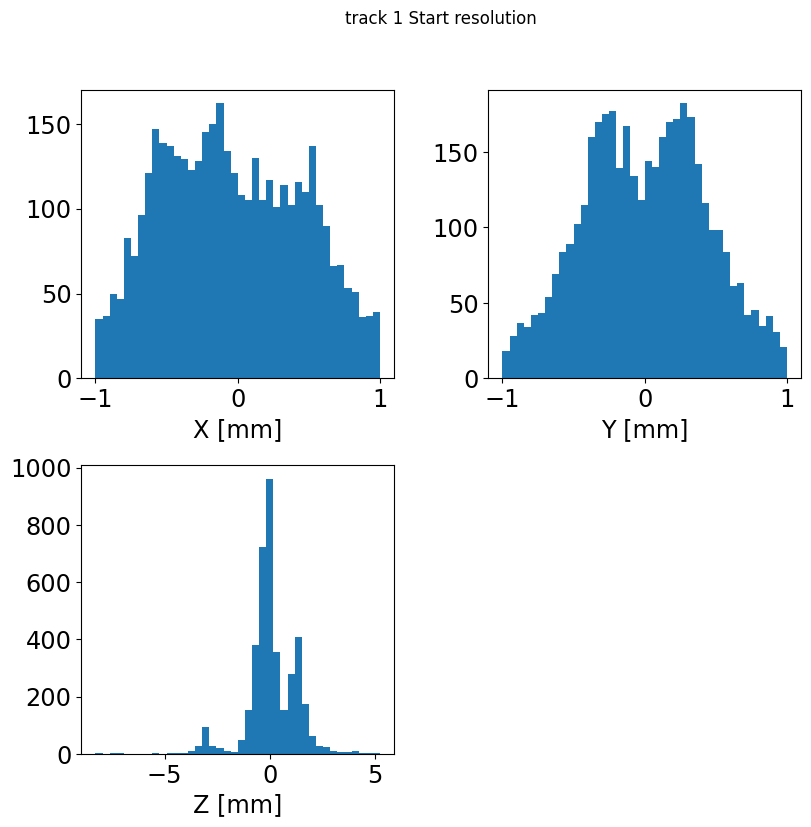

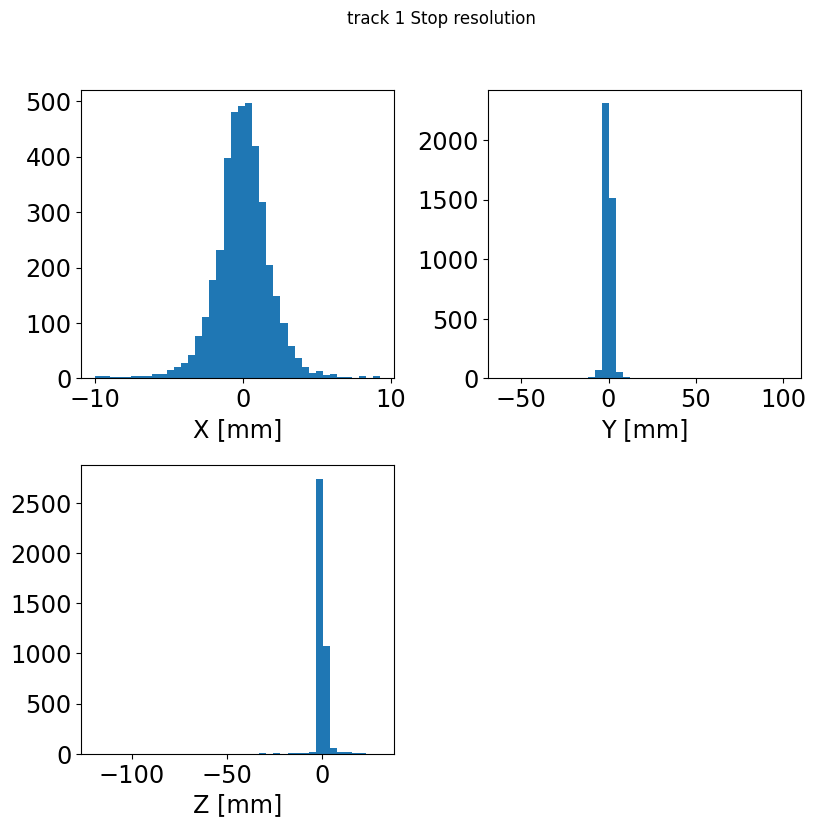

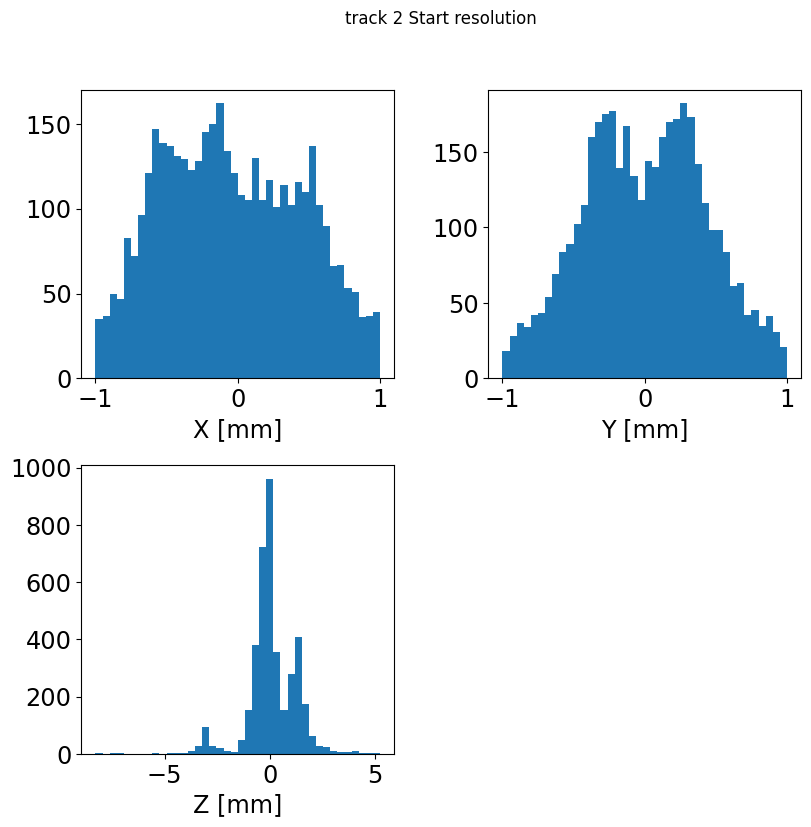

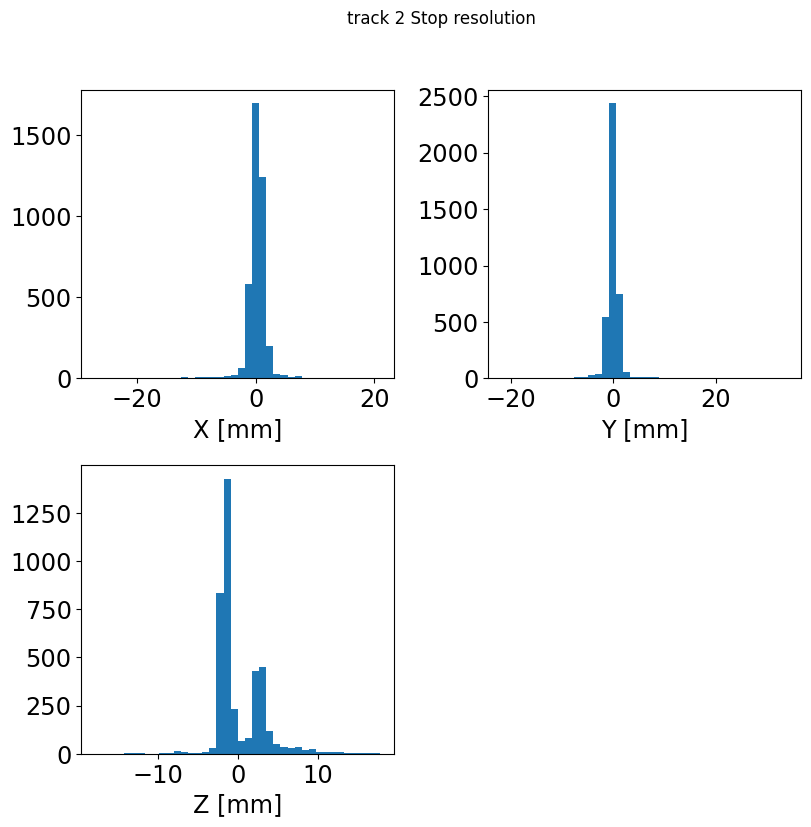

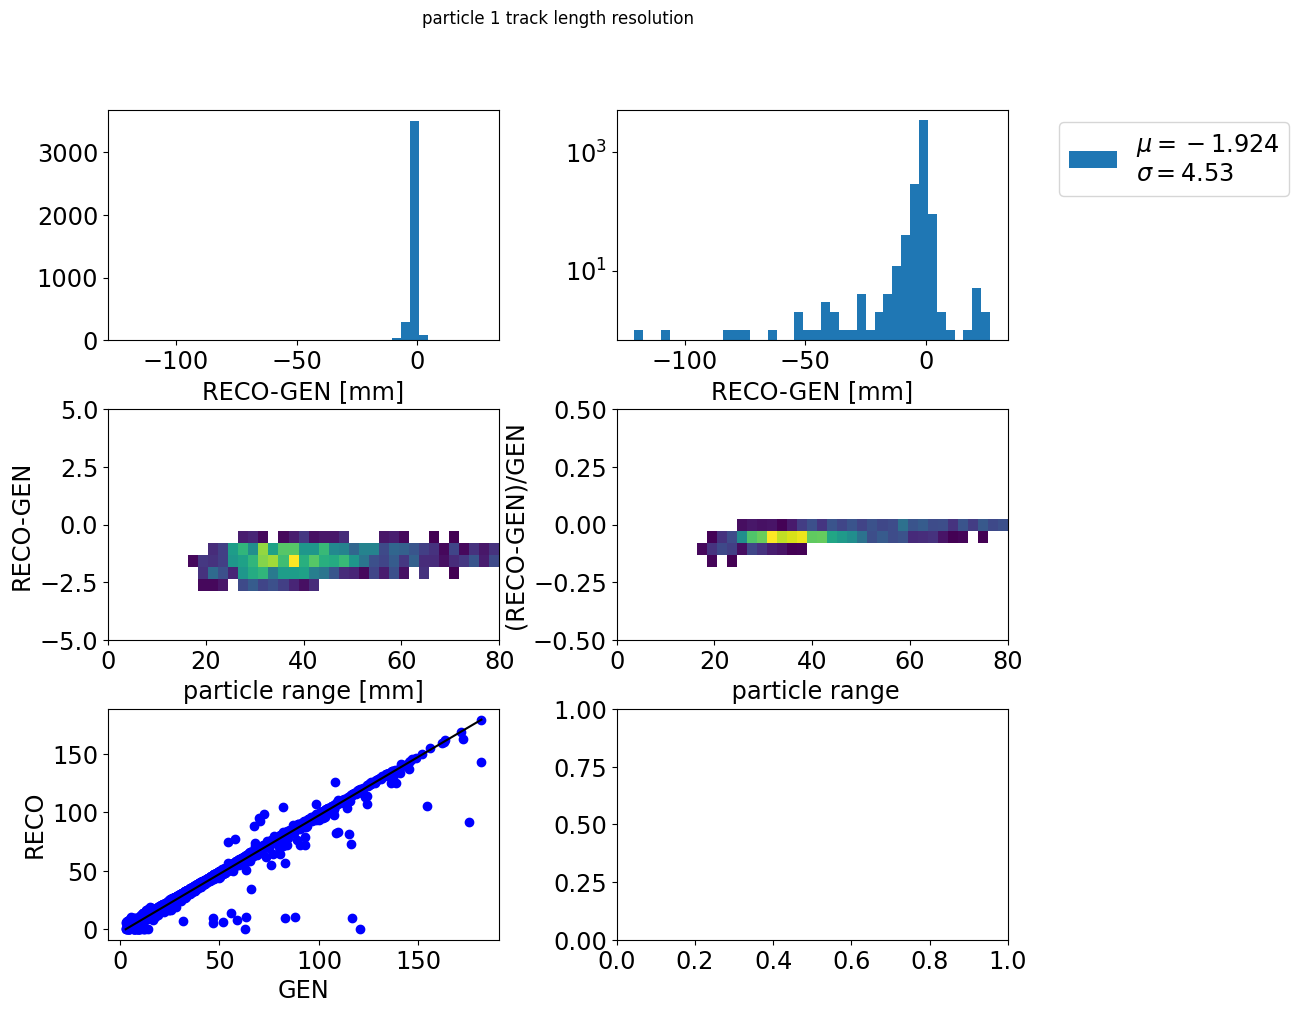

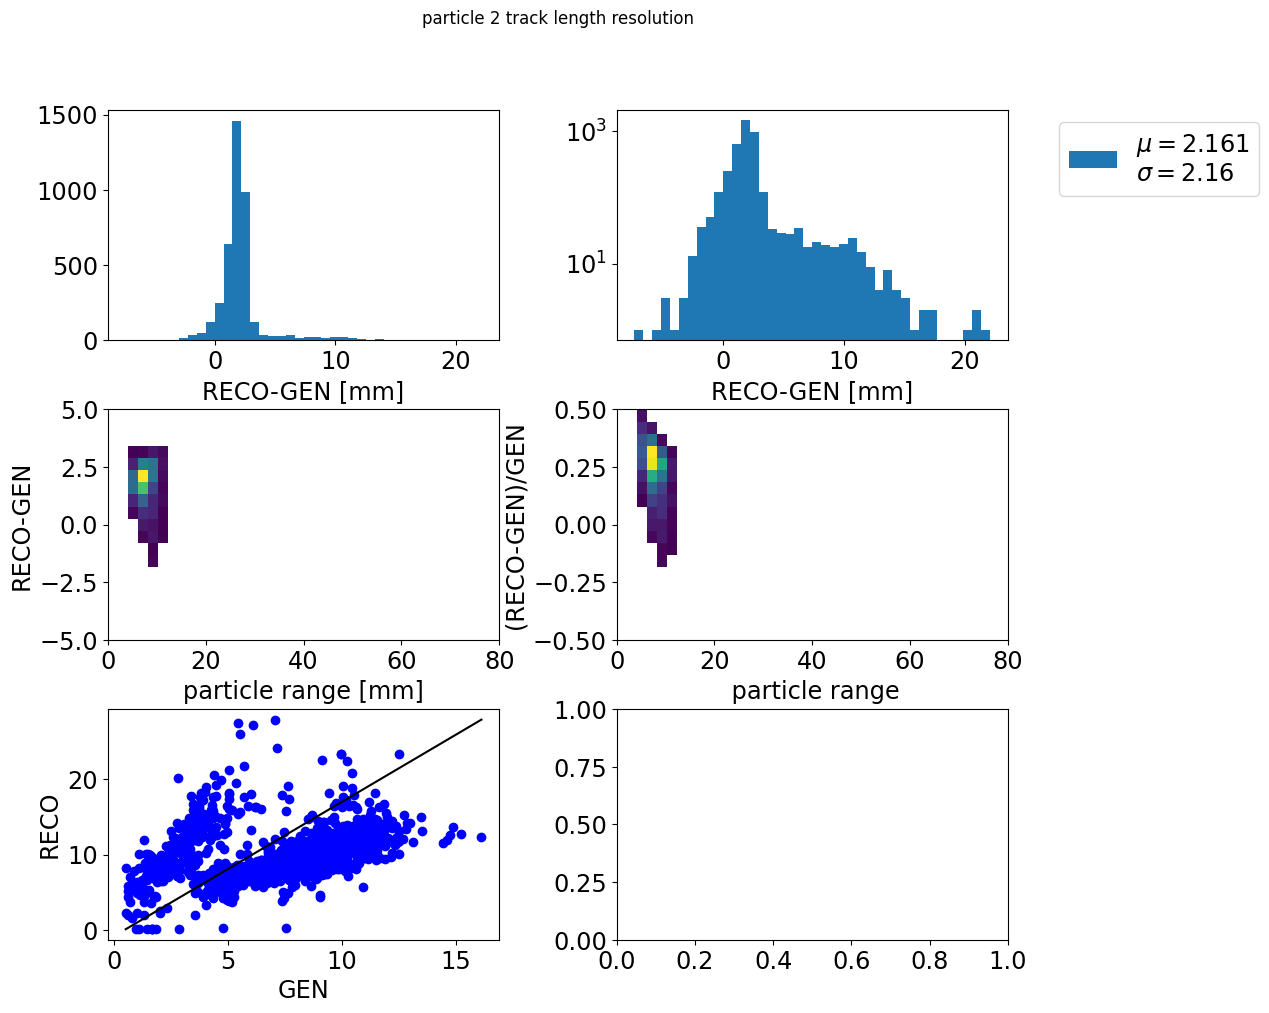

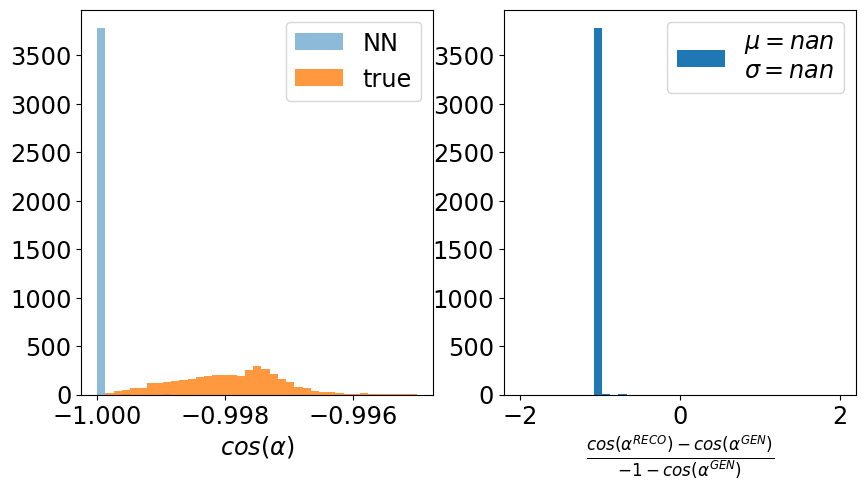

In [5]:
mask = np.abs(df["GEN_StartPosX"] - df["RECO_StartPosX"])<1
df_filtered = df[mask]

mask = np.abs(df_filtered["GEN_StartPosY"] - df_filtered["RECO_StartPosY"])<1
df_filtered = df_filtered[mask]

mask = np.abs(df_filtered["GEN_StopPosX_Part1"] - df_filtered["RECO_StopPosX_Part1"])<10
df_filtered = df_filtered[mask]

print(df_filtered.describe())

plf.plotEndPointRes(df=df_filtered, edge="Start", partIdx=1)
plf.plotEndPointRes(df=df_filtered, edge="Stop", partIdx=1)

plf.plotEndPointRes(df=df_filtered, edge="Start", partIdx=2)
plf.plotEndPointRes(df=df_filtered, edge="Stop", partIdx=2)

plf.plotLengthPull(df_filtered, partIdx=1)
plf.plotLengthPull(df_filtered, partIdx=2)
plf.plotOpeningAngleCos(df_filtered)

## 2D plots 

KeyError: 'alphaRangeGen'

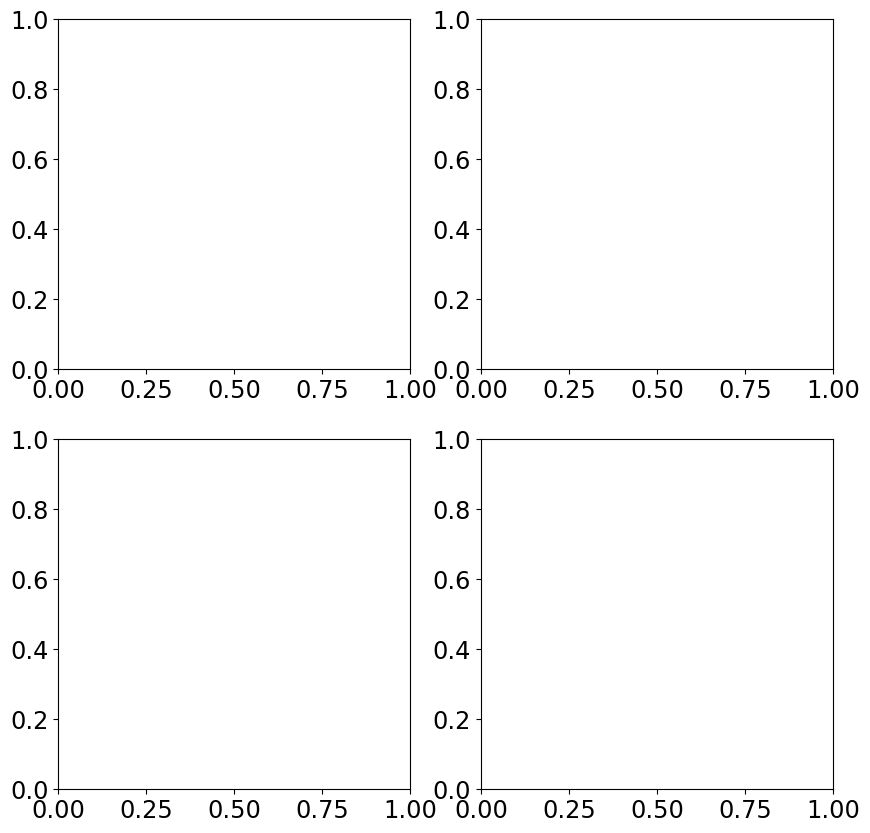

In [6]:
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (14, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         #'xticks':'major_ticks_top'
         }

plt.rcParams.update(params)


fig, axes = plt.subplots(2, 2, figsize = (10, 10))

'''
trackTree->Draw("(alphaRangeReco-alphaRangeGen)/alphaRangeGen:alphaRangeGen>>hRangeResVsRangeGen(21,0, 70,  41,-0.5,0.5)","","goff");
trackTree->Draw("(alphaRangeReco-alphaRangeGen)/alphaRangeGen:cosThetaGen>>hRangeResVsCosTheta(21,-1, 1,  41,-0.5,0.5)","","goff");
trackTree->Draw("abs(cosThetaReco)-abs(cosThetaGen):cosThetaGen>>hCosThetaResVsCosTheta(21,-1, 1,  41,-0.5,0.5)","","goff");
trackTree->Draw("asin(sin(phiReco-phiGen)):cosThetaGen>>hPhiResVsCosTheta(21,-1, 1,  41,-0.5,0.5)","","goff");
trackTree->Draw("(chargeReco-chargeGen)/chargeGen:cosThetaGen>>hChargeResVsCosTheta(21,-1, 1,  41,-0.5,0.5)","","goff");
'''

x = df["alphaRangeGen"]
y = df.eval("(alphaRangeReco -alphaRangeGen)/alphaRangeGen")
xBins = np.linspace(0,60,20)
yBins = np.linspace(-0.5,0.5,20)
axes[0,0].hist2d(x, y, bins=(xBins, yBins), cmin=10, label="length")
axes[0,0].set_xlabel(r'$\alpha~range [mm]$')
axes[0,0].set_ylabel(r'$\frac{RECO-GEN}{GEN}$')

x = df["cosThetaGen"]
xBins = np.linspace(-1,1,20)
yBins = np.linspace(-0.5,0.5,20)
axes[0,1].hist2d(x, y, bins=(xBins, yBins), cmin=10, label="length")
axes[0,1].set_xlabel(r'$\cos(\theta)$')
axes[0,1].set_ylabel(r'$\frac{RECO-GEN}{GEN}$')

x = df["phiGen"]
xBins = np.linspace(-np.pi,np.pi,20)
yBins = np.linspace(-0.5,0.5,20)
axes[1,0].hist2d(x, y, bins=(xBins, yBins), cmin=10, label="length")
axes[1,0].set_xlabel(r'$\varphi$')
axes[1,0].set_ylabel(r'$\frac{RECO-GEN}{GEN}$')

x = df["dEdxFitChi2"]
xBins = np.linspace(x.min(),x.median(),20)
yBins = np.linspace(-0.5,0.5,20)
axes[1,1].hist2d(x, y, bins=(xBins, yBins), cmin=10, label="length")
axes[1,1].set_xlabel(r'$\frac{dE}{dx}$ fit loss func.')
axes[1,0].set_ylabel(r'$\frac{RECO-GEN}{GEN}$')

plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.35, hspace=0.3)
#plt.savefig("fig_png/2D_plots.png", bbox_inches="tight")